In [2]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy
from nltk.corpus import stopwords 
stops = set(stopwords.words('english'))
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

from IPython.display import Image

unable to import 'smart_open.gcs', disabling that module


In [2]:
#read in the data from the kaggle download

dfo = pd.read_csv('2020-03-13/all_sources_metadata_2020-03-13.csv')

In [3]:
print(f'The size of our df is, {dfo.shape}')

The size of our df is, (29500, 14)


In [4]:
#drop features we do not need
df = dfo.drop(['sha', 'source_x', 'pmcid', 'doi', 'pubmed_id', 'license'], axis = 1)

In [5]:
#get rid of rows where there is no abstract
df = df[df['abstract'].notna()]

In [6]:
print(f'The size of our df is after dropping null values and some features, {df.shape} \n \
        The amount of obs lost = {len(dfo) - len(df)}' )

The size of our df is after dropping null values and some features, (26553, 8) 
         The amount of obs lost = 2947


In [7]:
df.head()

,title,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
2,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
5,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,3.006029e+09,#729,True
6,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,3.006029e+09,#865,True
8,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,3.006304e+09,#2926,True


In [9]:
df['all_text'] = df.title.str.cat(df.abstract,sep=" ")

In [10]:
#quick sanity check
if df.all_text.iloc[10000] == df.title.iloc[10000] + " " + df.abstract.iloc[10000]:
    print(0)
else:
    print(-1)

0


In [11]:
#We are going to create a Topic model based on the Titles, abstracts, and both
t_data = df.title.values.tolist() 
a_data = df.abstract.values.tolist()
all_data = df.all_text.values.tolist()

In [12]:
#double checking that they are all the same size
print(f'The length of titile corpus = {len(t_data)} \n \
        The lenght of the abstract corpus = {len(a_data)} \n \
        The length of all the data = {len(all_data)}')

The length of titile corpus = 26553 
         The lenght of the abstract corpus = 26553 
         The length of all the data = 26553


In [13]:
def ppreprocess(data):
    import re
    temp = data.copy()
    temp = [re.sub("\'", "", x) for x in temp] #remove single quotes
    temp = [re.sub("\,", "", x) for x in temp] #remove commas, technically don't need to but I like too
    for sentence in temp:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

In [14]:
#where the first two characters indicate the datas cleaning step; sp is simple preprocess
spt_data = list(ppreprocess(t_data))

In [15]:
dpa_data = list(ppreprocess(a_data))

In [16]:
spall_data = list(ppreprocess(all_data))

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(spall_data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[spall_data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#interesting to note that we do not see any trigrams, indicating that we did not meet the threshold, which we could perhaps lower
print(trigram_mod[bigram_mod[spall_data[0]]])

['incubation_period', 'and', 'other', 'epidemiological', 'characteristics', 'of', 'novel', 'coronavirus', 'infections', 'with', 'right', 'truncation', 'statistical', 'analysis', 'of', 'publicly_available', 'case', 'data', 'the', 'geographic', 'spread', 'of', 'novel', 'coronavirus', 'covid', 'infections', 'from', 'the', 'epicenter', 'of', 'wuhan_china', 'has', 'provided', 'an', 'opportunity', 'to', 'study', 'the', 'natural', 'history', 'of', 'the', 'recently', 'emerged', 'virus', 'using', 'publicly_available', 'event', 'date', 'data', 'from', 'the', 'ongoing', 'epidemic', 'the', 'present', 'study', 'investigated', 'the', 'incubation_period', 'and', 'other', 'time', 'intervals', 'that', 'govern', 'the', 'epidemiological', 'dynamics', 'of', 'covid', 'infections', 'our', 'results', 'show', 'that', 'the', 'incubation_period', 'falls', 'within', 'the', 'range', 'of', 'ndash', 'days', 'with', 'confidence', 'and', 'has', 'mean', 'of', 'around', 'days', 'when', 'approximated', 'using', 'the', '

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stops] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [19]:
# Remove Stop Words
spall_data_words_nostops = remove_stopwords(spall_data)

# Form Bigrams
spall_data_words_bigrams = make_bigrams(spall_data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
spdata_lemmatized = lemmatization(spall_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(spdata_lemmatized[:1])

[['epidemiological', 'characteristic', 'novel', 'infection', 'right', 'truncation', 'statistical', 'analysis', 'publicly_available', 'case', 'data', 'spread', 'novel', 'provide', 'opportunity', 'study', 'natural', 'history', 'recently', 'emerge', 'virus', 'use', 'publicly_available', 'event', 'date', 'datum', 'ongoing', 'epidemic', 'present', 'study', 'investigate', 'time', 'interval', 'govern', 'epidemiological', 'dynamic', 'covid', 'infection', 'result', 'show', 'fall', 'range', 'ndash', 'day', 'confidence', 'mean', 'day', 'approximate', 'use', 'best', 'fit', 'mean', 'treatment', 'isolation', 'estimate', 'ndash', 'day', 'truncation', 'ndash', 'day', 'right', 'truncate', 'base', 'estimate', 'length', 'quarantine', 'least', 'day', 'median', 'time', 'onset', 'death', 'day', 'right', 'truncation', 'consider', 'estimate', 'covid', 'case_fatality', 'risk']]


In [20]:
#lets create the main inputs into the LDA model, which are the id2word(doc), which is dictionary of the word index adn frequency per document
#the other input to add is the corpus , which is the entire id2word(doc) collection, so it can be thought of as a nested dictionary 
# Create Dictionary
id2word = corpora.Dictionary(spdata_lemmatized)

# Create Corpus
texts = spdata_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 6), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 3), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 2), (53, 1), (54, 1), (55, 3), (56, 2), (57, 1)]]


In [21]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('analysis', 1),
  ('approximate', 1),
  ('base', 1),
  ('best', 1),
  ('case', 1),
  ('case_fatality', 1),
  ('characteristic', 1),
  ('confidence', 1),
  ('consider', 1),
  ('covid', 2),
  ('data', 1),
  ('date', 1),
  ('datum', 1),
  ('day', 6),
  ('death', 1),
  ('dynamic', 1),
  ('emerge', 1),
  ('epidemic', 1),
  ('epidemiological', 2),
  ('estimate', 3),
  ('event', 1),
  ('fall', 1),
  ('fit', 1),
  ('govern', 1),
  ('history', 1),
  ('infection', 2),
  ('interval', 1),
  ('investigate', 1),
  ('isolation', 1),
  ('least', 1),
  ('length', 1),
  ('mean', 2),
  ('median', 1),
  ('natural', 1),
  ('ndash', 3),
  ('novel', 2),
  ('ongoing', 1),
  ('onset', 1),
  ('opportunity', 1),
  ('present', 1),
  ('provide', 1),
  ('publicly_available', 2),
  ('quarantine', 1),
  ('range', 1),
  ('recently', 1),
  ('result', 1),
  ('right', 3),
  ('risk', 1),
  ('show', 1),
  ('spread', 1),
  ('statistical', 1),
  ('study', 2),
  ('time', 2),
  ('treatment', 1),
  ('truncate', 1),
  ('trunc

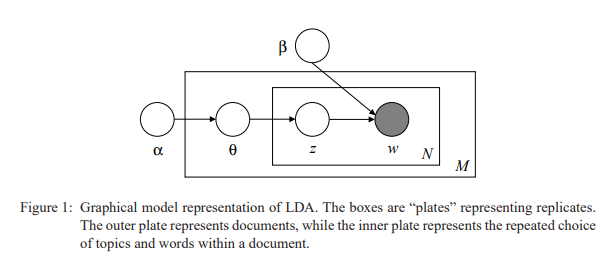

In [3]:
Image(filename = "Lda.png")
#where corpus is collectino of M documents [D]
#Doc containts N words
#Z is topic selected
#solve p(wN | Zn , ThetaN)

In [22]:
# Build LDA model; can be fine tuned for coherence and perplexity, where K = num_topics, we are updating every iteration

#k is important because it
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.160*"lung" + 0.154*"lesion" + 0.112*"length" + 0.062*"pulmonary" + '
  '0.044*"uninfected" + 0.043*"subset" + 0.041*"reverse" + 0.038*"image" + '
  '0.036*"mixed" + 0.024*"peripheral"'),
 (1,
  '0.237*"response" + 0.166*"vaccine" + 0.151*"immune" + 0.093*"epitope" + '
  '0.053*"induce" + 0.033*"protection" + 0.029*"map" + 0.025*"state" + '
  '0.020*"way" + 0.020*"experimental"'),
 (2,
  '0.218*"activity" + 0.122*"treatment" + 0.102*"drug" + 0.053*"fold" + '
  '0.050*"anti" + 0.049*"treat" + 0.035*"compound" + 0.033*"phase" + '
  '0.032*"therapy" + 0.029*"target"'),
 (3,
  '0.510*"model" + 0.126*"growth" + 0.070*"stable" + 0.066*"trigger" + '
  '0.044*"wide" + 0.017*"forecast" + 0.011*"keep" + 0.008*"uncertainty" + '
  '0.005*"generalize" + 0.004*"cumulative"'),
 (4,
  '0.104*"dose" + 0.099*"exposure" + 0.078*"contact" + 0.042*"antibiotic" + '
  '0.039*"route" + 0.038*"interval" + 0.035*"oral" + 0.035*"expose" + '
  '0.029*"person" + 0.028*"suppression"'),
 (5,
  '0.072*"patie

In [27]:
# Compute Perplexity; lower the better
#mallet is better than the LDA implementation 
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score, interpreted similarly to acc
coherence_model_lda = CoherenceModel(model=lda_model, texts= spdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.481325569592586

Coherence Score:  0.4068010157040322


In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\users\eovit\miniconda3\envs\virt\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.290440  0.070622       1        1  23.542379
13    -0.227321 -0.028377       2        1  13.771547
19    -0.248160 -0.075813       3        1  13.389508
15    -0.217426  0.252661       4        1  11.200956
9     -0.202651  0.118081       5        1  10.444012
5     -0.149102 -0.124459       6        1   7.274592
12     0.026618 -0.150288       7        1   3.022837
11    -0.031423 -0.206122       8        1   2.576866
18    -0.034992 -0.207488       9        1   2.509010
1      0.050523  0.120532      10        1   2.128609
6      0.026237  0.104777      11        1   1.985927
2      0.048774  0.052650      12        1   1.967890
16     0.036287 -0.155116      13        1   1.540049
17     0.098214  0.027919      14        1   1.375771
4      0.159778  0.028512      15        1   0.826485
3      0.157446  0.035583      16        1   0.763243
14     0.191847  0.037047      17        1   0.503758
0      0.193873  0.034221      18        1   0.466151
10     0.199722  0.032639      19        1   0.403183
8      0.212196  0.032417      20        1   0.307229, topic_info=     Category          Freq         Term         Total  loglift  logprob
57    Default  83303.000000        virus  83303.000000  30.0000  30.0000
323   Default  50984.000000         cell  50984.000000  29.0000  29.0000
355   Default  39376.000000      protein  39376.000000  28.0000  28.0000
75    Default  19493.000000      disease  19493.000000  27.0000  27.0000
661   Default  17702.000000         gene  17702.000000  26.0000  26.0000
...       ...           ...          ...           ...      ...      ...
6997  Topic20      0.066042         calf      1.576807   2.6125 -11.7839
2891  Topic20      0.066036       piglet      1.576507   2.6126 -11.7840
2447  Topic20      0.066043  replication      1.577068   2.6123 -11.7839
2023  Topic20      0.066036      examine      1.576681   2.6125 -11.7840
2601  Topic20      0.066036        serum      1.576687   2.6124 -11.7840

[879 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1030      1  0.999046        able
440      13  0.996728  accelerate
441      15  0.992197      accept
611       7  0.997715      access
442       9  0.997519  accurately
...     ...       ...         ...
312       2  0.999591       would
726       2  0.196987        year
726       6  0.802687        year
1066     11  0.982741    year_old
1461      6  0.998883       young

[1021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 14, 20, 16, 10, 6, 13, 12, 19, 2, 7, 3, 17, 18, 5, 4, 15, 1, 11, 9])

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts= spdata_lemmatized, start=2, limit=40, step=2)

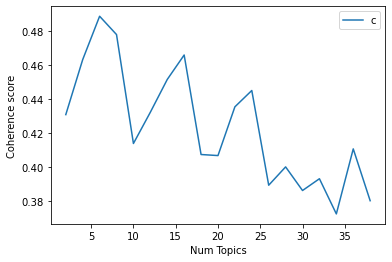

In [40]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4308
Num Topics = 4  has Coherence Value of 0.4631
Num Topics = 6  has Coherence Value of 0.4885
Num Topics = 8  has Coherence Value of 0.4778
Num Topics = 10  has Coherence Value of 0.4139
Num Topics = 12  has Coherence Value of 0.4322
Num Topics = 14  has Coherence Value of 0.4514
Num Topics = 16  has Coherence Value of 0.4658
Num Topics = 18  has Coherence Value of 0.4074
Num Topics = 20  has Coherence Value of 0.4068
Num Topics = 22  has Coherence Value of 0.4354
Num Topics = 24  has Coherence Value of 0.445
Num Topics = 26  has Coherence Value of 0.3894
Num Topics = 28  has Coherence Value of 0.4002
Num Topics = 30  has Coherence Value of 0.3863
Num Topics = 32  has Coherence Value of 0.3932
Num Topics = 34  has Coherence Value of 0.3726
Num Topics = 36  has Coherence Value of 0.4107
Num Topics = 38  has Coherence Value of 0.3803


In [42]:
# Select the model and print the topics
#LDA is a generative model, so you are not guranteed convergence, or consistency runs
#MCMC method
#Gibbs iterative sampling

optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.499*"model" + 0.068*"stable" + 0.064*"trigger" + 0.050*"parameter" + '
  '0.045*"cancer" + 0.038*"predict" + 0.035*"organ" + 0.017*"forecast" + '
  '0.008*"explain" + 0.005*"generalize"'),
 (1,
  '0.304*"patient" + 0.058*"lesion" + 0.044*"blood" + 0.023*"pulmonary" + '
  '0.022*"hospital" + 0.022*"lung" + 0.021*"clinical" + 0.021*"normal" + '
  '0.019*"fever" + 0.018*"male"'),
 (2,
  '0.227*"activity" + 0.080*"protease" + 0.069*"product" + 0.065*"enzyme" + '
  '0.057*"inhibitor" + 0.056*"inhibition" + 0.053*"target" + 0.050*"drug" + '
  '0.036*"compound" + 0.021*"library"'),
 (3,
  '0.045*"system" + 0.038*"base" + 0.035*"pig" + 0.032*"approach" + '
  '0.031*"use" + 0.030*"method" + 0.026*"tool" + 0.022*"research" + '
  '0.022*"information" + 0.020*"prediction"'),
 (4,
  '0.106*"vaccine" + 0.069*"treatment" + 0.046*"line" + 0.032*"bacterial" + '
  '0.031*"drug" + 0.027*"treat" + 0.027*"effective" + 0.026*"agent" + '
  '0.026*"antiviral" + 0.025*"therapeutic"'),
 (5,
  '0.086*"

In [43]:
#is our perplexity better than our manual model?
#-12.14, actually better 
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -12.144665132888994


In [2]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
# vis

In [59]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=spall_data):
    # Init output
    covid_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0: 
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     covid_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     covid_topics_df = pd.concat([covid_topics_df, contents], axis=1)
#     return(covid_topics_df)

In [ ]:
#lets use the function defined above!
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=spall_data)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # Show
# df_dominant_topic.head(10)

([(4, 0.019476691), (5, 0.19176973), (7, 0.36807087), (9, 0.03652651), (10, 0.04912884), (11, 0.013906792), (13, 0.28142306), (15, 0.018516872)], [(0, [7, 6, 9]), (1, [7]), (2, [7, 13, 11]), (3, [7]), (4, [13, 5]), (5, [7]), (6, [13, 7, 5, 9]), (7, [7]), (8, [13, 7, 5]), (9, []), (10, [13, 3]), (11, [13, 9]), (12, [13, 7]), (13, [5]), (14, [5, 13, 15]), (15, [13]), (16, [13, 9]), (17, [13]), (18, [13, 5]), (19, [10]), (20, [13]), (21, [7]), (22, [13]), (23, [7]), (24, [13, 5]), (25, [5, 15]), (26, [5, 7]), (27, [7, 5]), (28, [11, 13]), (29, [7, 5, 11]), (30, [7]), (31, [5, 13, 7]), (32, [5]), (33, [13, 7, 9, 4]), (34, []), (35, [13, 9, 4, 6]), (36, [13]), (37, [5]), (38, [7]), (39, [7, 13, 5, 9]), (40, [13, 7, 9, 4]), (41, [7]), (42, [13]), (43, [13, 7, 5, 9, 11]), (44, [7, 9]), (45, [7, 5]), (46, [13]), (47, [13, 5]), (48, [7, 9, 15]), (49, [13]), (50, [7]), (51, [7, 5]), (52, [10, 7, 13, 5]), (53, [4]), (54, [7]), (55, [7]), (56, [7, 13, 11]), (57, [5, 9, 11, 15])], [(0, [(6, 0.02336